## Natural gradients can help the DGP model considerably

This is epecially true with a Gaussian likelihood. Here we show an example of 1D regression (with thanks to Loïc Brevault for the test function)


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from gpflow import autoflow, params_as_tensors
from gpflow import settings
from gpflow.mean_functions import Zero, Linear
from gpflow.likelihoods import Gaussian as Gaussian_lik
from gpflow.kernels import RBF, White
from gpflow.training import AdamOptimizer, NatGradOptimizer
from gpflow.actions import Action, Loop

from doubly_stochastic_dgp.dgp import DGP


/Users/hughsalimbeni/anaconda3/envs/prowler_env/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/hughsalimbeni/anaconda3/envs/prowler_env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/hughsalimbeni/anaconda3/envs/prowler_env/lib/python3.5/site-packages/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Linear, NoneType, Sum, InducingPoints], [Gaussian, Identity, NoneType, Kernel, InducingPoints]


Consider making the following additions:

@dispatch(Gauss

In [2]:
f = lambda X: -(np.multiply(np.sin(40*np.power((X-0.85),4)), np.cos(2.5*(X-0.95)))+(X-0.9)/2+1)/2

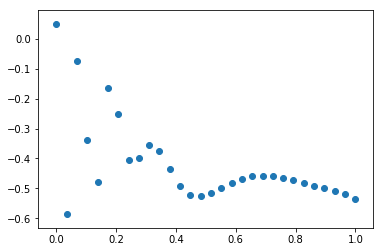

In [3]:
X = np.linspace(0, 1, 30).reshape(-1, 1)
Y = f(X)
plt.scatter(X, Y)
plt.show()

In [4]:
def make_dgp2(X, Y):
    kernels = [RBF(1, lengthscales=0.1), RBF(1, lengthscales=0.1)]
    model = DGP(X, Y, X, kernels, Gaussian_lik(), num_samples=10)
    model.likelihood.likelihood.variance = 1e-4
    for layer in model.layers[:-1]:
        layer.q_sqrt = layer.q_sqrt.value * 1e-5
    return model

We'll create the model twice and optimize one with Adam alone and the other with natural gradients for the final layer with Adam for the inner layer and all hyperparmeters and inducing points

In [5]:
model_adam = make_dgp2(X, Y)
model_nat_grads = make_dgp2(X, Y)

iterations = 5000

In [6]:
AdamOptimizer(0.001).minimize(model_adam, maxiter=iterations)


In [7]:
ng_vars = [[model_nat_grads.layers[-1].q_mu, model_nat_grads.layers[-1].q_sqrt]]
for v in ng_vars[0]:
    v.set_trainable(False)
ng_action = NatGradOptimizer(gamma=1.).make_optimize_action(model_nat_grads, var_list=ng_vars)
adam_action = AdamOptimizer(0.001).make_optimize_action(model_nat_grads)

Loop([ng_action, adam_action], stop=iterations)()

    

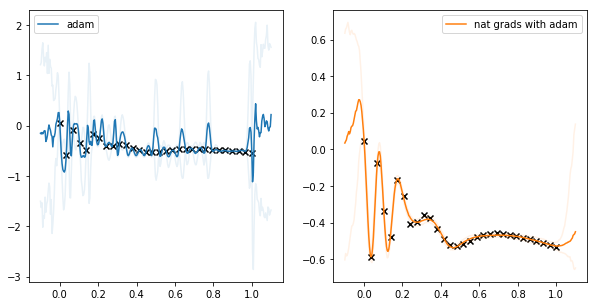

In [35]:
Xs = np.linspace(-0.1, 1.1, 300).reshape(-1, 1)


def plot(ax, model, name, c):
    Fs, ms, vs = model.predict_all_layers_full_cov(Xs, 100)
    qs = [np.percentile(Fs[-1][:, :, -1], q, axis=0) for q in [10., 50., 90.]]

    ax.plot(Xs, qs[0], alpha=0.1, color=c)
    ax.plot(Xs, qs[1], alpha=1, label=name, color=c)
    ax.plot(Xs, qs[2], alpha=0.1, color=c)
    ax.scatter(X, Y, marker='x', color='k')
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot(axs[0], model_adam, 'adam', 'C0')
plot(axs[1], model_nat_grads, 'nat grads with adam', 'C1')
plt.show()
